## 📋 Project Overview & Reflections

### 1. 🧩 Assumptions, Definitions, and Problem Scope
- **Prospects** are users on the free tier who have not yet converted to paying customers.
- **Conversion** is defined as transitioning from a non-paying user to a paying customer (based on MRR > 0).
- The goal is to identify **behavioral and firmographic features** that separate converters from non-converters and build a model that predicts **likely future conversions**.
- The CRM usage data includes actions on four objects: **Contacts, Companies, Deals, and Emails**, which are central to this prediction.
- We assume usage logs can occur both before and after conversion, and include all available activity for modeling.

### 2. 📊 EDA and Data Thoughts
- Customers show **significantly higher CRM activity** than non-customers, particularly in Deals and Contacts objects.
- **Recency of activity** is a clear signal: users who recently interacted with the CRM are more likely to convert.
- Certain employee ranges (e.g., `26 to 200`) and industries (like **SaaS** and **E-Learning**) correlate with higher conversion rates.
- Missing values in `INDUSTRY` and `EMPLOYEE_RANGE` were labeled as "Unknown" and encoded for modeling.

### 3. 🤖 Modeling Methodologies and Rationale
- We used a **Random Forest Classifier** due to its robustness with:
  - Mixed feature types (numerical and categorical)
  - Minimal preprocessing requirements
  - Built-in **feature importance** interpretation
- The model was trained on historical usage and metadata, and evaluated using **accuracy, precision, recall, F1-score, and ROC-AUC**.
- Features such as **CRM action frequency, activity span, and recency** were included due to their observed correlation with conversion.

### 4. ✅ Results and Conclusions with Business Recommendations
- The model performed well, with:
  - **ROC AUC ≈ 0.96**
  - **Precision ≈ 0.85** and **Recall ≈ 0.59** for converters
- **Top predictive features**: CRM Contacts activity, Deals activity, total actions, and recency.
- **Business Recommendations**:
  - Focus sales and customer success outreach on **recently active users** with **high CRM usage**.
  - Prioritize leads in **industries and company sizes** with higher conversion rates.
  - Use the model for **weekly scoring** of prospects to inform real-time strategy.

### 5. 🔮 Next Steps and Future Directions
- Incorporate **time-series trends** (e.g., week-over-week usage growth).
- Include **deal pipeline status or notes** as part of the feature set.
- Explore **NLP analysis on email content** (if available) for sentiment and intent.
- Build an automated **weekly batch pipeline** for lead scoring and integrate with Salesforce.
- Investigate modeling **MRR prediction** as a regression task for revenue forecasting.


## 📦 Step 1: Import Required Libraries

We begin by importing essential Python libraries for data manipulation, visualization, machine learning, and evaluation.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix 

## 📥 Step 2: Load HubSpot Datasets

We load the customer, non-customer, and CRM usage action datasets using pandas. These datasets will be used to build a labeled dataset for analysis and modeling.

In [3]:
customers = pd.read_excel(r"C:\Users\hp\Downloads\customers_(4).xlsx")
noncustomers = pd.read_excel(r"C:\Users\hp\Downloads\noncustomers_(4).xlsx")
usage = pd.read_excel(r"C:\Users\hp\Downloads\usage_actions_(4).xlsx")

## 🔖 Step 3: Label and Merge Customer Metadata

We add a binary label (`is_customer`) to distinguish between paying customers and free-tier users. Then, we align and merge metadata for both groups into a single dataset.
## 🔗 Step 4: Merge Usage Data

We convert the timestamp to datetime format and merge the usage actions data with the combined customer metadata using the unique company ID.

In [5]:
# Add labels
customers["is_customer"] = 1
noncustomers["is_customer"] = 0

# Align column names and merge
customers_meta = customers[["id", "ALEXA_RANK", "EMPLOYEE_RANGE", "INDUSTRY", "is_customer"]]
noncustomers_meta = noncustomers[["id", "ALEXA_RANK", "EMPLOYEE_RANGE", "INDUSTRY", "is_customer"]]
combined_meta = pd.concat([customers_meta, noncustomers_meta])

# Merge with usage
usage["WHEN_TIMESTAMP"] = pd.to_datetime(usage["WHEN_TIMESTAMP"])
merged = usage.merge(combined_meta, on="id", how="left")

## 📊 Step 5: Aggregate CRM Usage Activity

We aggregate CRM usage activity by company ID. This includes summing total actions and users per object (Contacts, Companies, Deals, Email), and calculating active days, activity span, and recency.
## 🧩 Step 6: Merge Aggregated Usage with Customer Metadata

We merge the aggregated CRM activity features with the metadata (employee range, industry, etc.) to create the final modeling dataset.

In [7]:
# Aggregate usage per company
usage_agg = merged.groupby("id").agg({
    "ACTIONS_CRM_CONTACTS": "sum",
    "ACTIONS_CRM_COMPANIES": "sum",
    "ACTIONS_CRM_DEALS": "sum",
    "ACTIONS_EMAIL": "sum",
    "USERS_CRM_CONTACTS": "sum",
    "USERS_CRM_COMPANIES": "sum",
    "USERS_CRM_DEALS": "sum",
    "USERS_EMAIL": "sum",
    "WHEN_TIMESTAMP": ["nunique", "min", "max"]
})

# Flatten multi-index columns
usage_agg.columns = ["_".join(col) for col in usage_agg.columns]
usage_agg = usage_agg.reset_index()

# Calculate span and recency
usage_agg["activity_span_days"] = (usage_agg["WHEN_TIMESTAMP_max"] - usage_agg["WHEN_TIMESTAMP_min"]).dt.days
usage_agg["recency_days"] = (merged["WHEN_TIMESTAMP"].max() - usage_agg["WHEN_TIMESTAMP_max"]).dt.days
usage_agg["total_actions"] = (
    usage_agg["ACTIONS_CRM_CONTACTS_sum"] + usage_agg["ACTIONS_CRM_COMPANIES_sum"] +
    usage_agg["ACTIONS_CRM_DEALS_sum"] + usage_agg["ACTIONS_EMAIL_sum"]
)

# Merge with metadata
final = usage_agg.merge(combined_meta, on="id", how="left")

## 📈 Step 7: Visualize Action Distribution

We visualize the distribution of total CRM actions to compare customers and non-customers. This helps identify behavior-based conversion patterns.

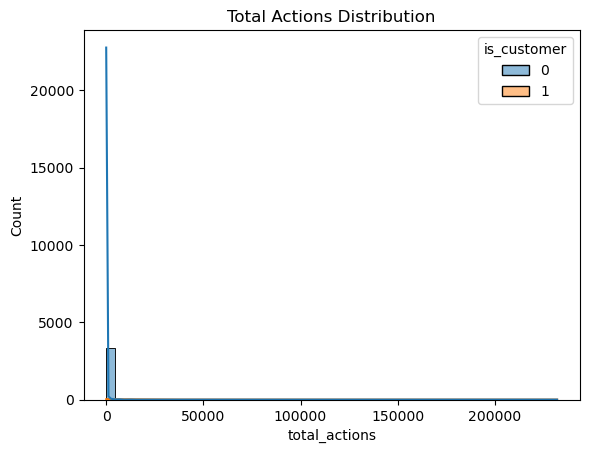

In [9]:
sns.histplot(data=final, x="total_actions", hue="is_customer", bins=50, kde=True)
plt.title("Total Actions Distribution")
plt.show()

## 🔠 Step 8: Handle Missing Values and Encode Categorical Data

We fill missing values in `EMPLOYEE_RANGE` and `INDUSTRY`, and then use Label Encoding to convert these categorical features into numerical format suitable for machine learning models.

In [13]:
# Handle missing
final["EMPLOYEE_RANGE"] = final["EMPLOYEE_RANGE"].fillna("Unknown").astype(str)
final["INDUSTRY"] = final["INDUSTRY"].fillna("Unknown").astype(str)

# Encode categorical
from sklearn.preprocessing import LabelEncoder

le_emp = LabelEncoder()
le_ind = LabelEncoder()

final["EMPLOYEE_RANGE_ENC"] = le_emp.fit_transform(final["EMPLOYEE_RANGE"].astype(str))
final["INDUSTRY_ENC"] = le_ind.fit_transform(final["INDUSTRY"].astype(str))

## ✂️ Step 9: Select Features and Split Data

We define relevant features for our model, separate the input variables (X) and target label (y), and perform an 80/20 train-test split.

In [15]:
features = [
    "ACTIONS_CRM_CONTACTS_sum", "ACTIONS_CRM_DEALS_sum", "ACTIONS_EMAIL_sum",
    "USERS_CRM_CONTACTS_sum", "USERS_EMAIL_sum", "activity_span_days",
    "recency_days", "total_actions", "ALEXA_RANK", "EMPLOYEE_RANGE_ENC", "INDUSTRY_ENC"
]
X = final[features]
y = final["is_customer"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🤖 Step 10: Train a Random Forest Classifier

We train a Random Forest model using the training data. This model is chosen for its ability to handle non-linearity and mixed data types, and for feature importance extraction.

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

## 📊 Step 11: Evaluate Model Performance

We evaluate the model using precision, recall, F1-score, accuracy, and ROC-AUC. A confusion matrix visualizes the model's classification performance.

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       665
           1       0.85      0.59      0.70        49

    accuracy                           0.96       714
   macro avg       0.91      0.79      0.84       714
weighted avg       0.96      0.96      0.96       714

ROC AUC Score: 0.9632346171551327


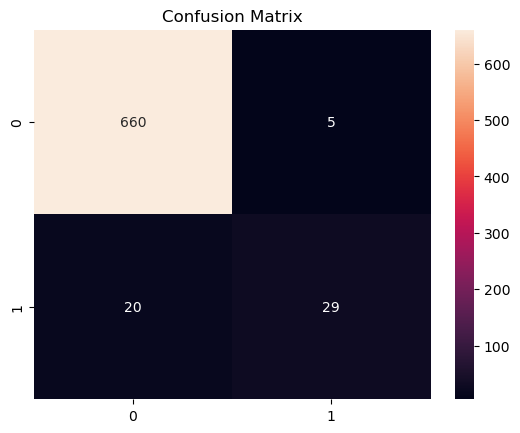

In [19]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

## 🧠 Step 12: Interpret Feature Importances

We analyze which features are most influential in predicting customer conversion. CRM actions and recency are among the top indicators.

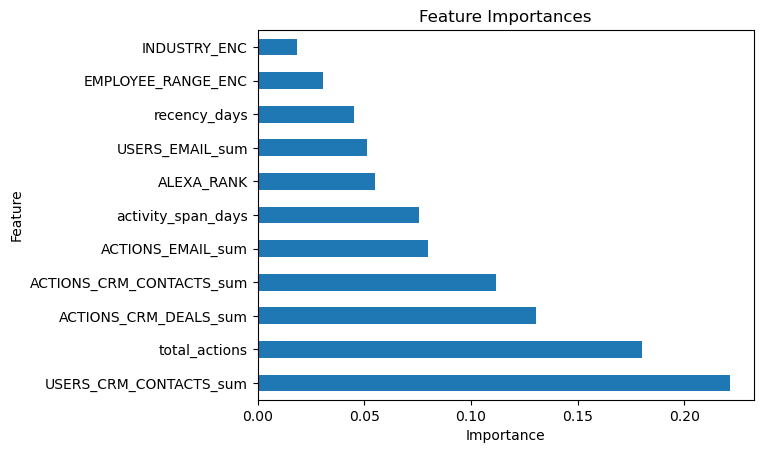

In [21]:
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
importances.plot(kind="barh", title="Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 🔮 Step 13: Predict Top Likely Converters

Using the trained model, we score all free-tier companies and identify the top 10 most likely to convert in the next month. This helps inform weekly sales strategy.

In [25]:
free_tier = final[final["is_customer"] == 0].copy()

# Predict probabilities
free_tier["conversion_probability"] = model.predict_proba(free_tier[features])[:, 1]

# Top 10 most likely converters
top_prospects = free_tier.sort_values(by="conversion_probability", ascending=False).head(10)
print(top_prospects[["id", "conversion_probability"]])

        id  conversion_probability
3046  4436                    0.97
1839  2652                    0.81
1509  2166                    0.68
2314  3350                    0.54
2357  3413                    0.52
3439  5001                    0.44
1446  2064                    0.39
363    469                    0.39
1814  2618                    0.38
2996  4346                    0.37
